<a href="https://colab.research.google.com/github/johngabriel613/Form-Validation/blob/main/THESIS_MODEL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Installing Libraries**

In [2]:
!pip install resampy
!pip install seaborn
!pip install pandas
!pip install numpy
!pip install librosa
!pip install seaborn
!pip install matplotlib
!pip install IPython
!pip install tensorflow
!pip install keras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 28.0 MB/s eta 0:00:00


**Connection to Drive**

In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


**Importing Libraries**

In [4]:
import os
import glob
import fnmatch
import pandas as pd
import numpy as np
import librosa # To deal with Audio files
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt
import IPython.display as ipd
import math
import tensorflow as tf
import fnmatch

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import concatenate
from tensorflow.keras.models import Sequential, Model, load_model

from tensorflow.keras.layers import Conv1D, Conv2D, SeparableConv1D, MaxPooling1D, MaxPooling2D
from tensorflow.keras.layers import Input, add, Flatten, Dense, BatchNormalization, Dropout, LSTM, GRU
from tensorflow.keras.layers import GlobalMaxPooling1D, GlobalMaxPooling2D, Activation, LeakyReLU, ReLU

from tensorflow.keras import regularizers
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef
from sklearn.metrics import cohen_kappa_score, roc_auc_score, confusion_matrix, classification_report


In [5]:
data_path = "../content/drive/MyDrive/Heartbeat_Sound/"
print(os.listdir(data_path))

['extrastole', 'artifact', 'normal', 'unlabel', 'murmur', 'extrahls']


In [6]:
tarin_data      = data_path
unlabel_data    = data_path  + "/unlabel/"

normal_data     = tarin_data + '/normal/'
murmur_data     = tarin_data + '/murmur/'
extrastole_data = tarin_data + '/extrastole/'
artifact_data   = tarin_data + '/artifact/'
extrahls_data   = tarin_data + "/extrahls/"

In [7]:
print("Normal files:", len(os.listdir(normal_data))) #length of normal training sounds
print("Murmur files:",len(os.listdir(murmur_data))) #length of murmur training sounds
print("Extrastole files", len(os.listdir(extrastole_data))) #length of extrastole training sounds
print("Artifact files:",len(os.listdir(artifact_data))) #length of artifact training sounds
print("Extrahls files:",len(os.listdir(extrahls_data))) #length of extrahls training sounds

print('TOTAL TRAIN SOUNDS:', len(os.listdir(normal_data))
                              + len(os.listdir(murmur_data))
                              + len(os.listdir(extrastole_data))
                              + len(os.listdir(artifact_data))
                              + len(os.listdir(extrahls_data)))

Normal files: 351
Murmur files: 129
Extrastole files 46
Artifact files: 40
Extrahls files: 19
TOTAL TRAIN SOUNDS: 585


**EDA and Visualization**

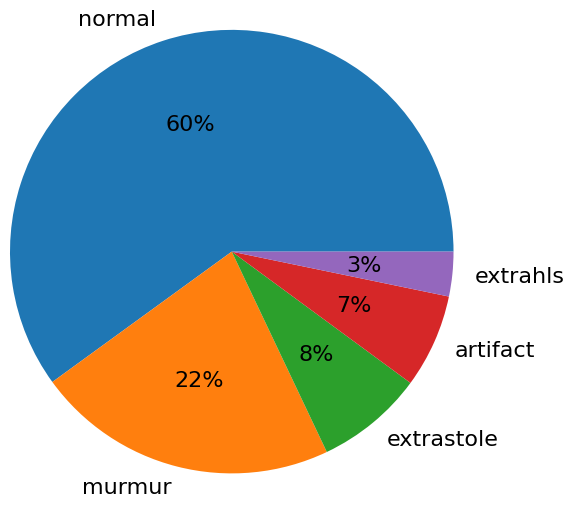

In [8]:
x = np.array([len(os.listdir(normal_data)),
              len(os.listdir(murmur_data)),
              len(os.listdir(extrastole_data)),
              len(os.listdir(artifact_data)),
              len(os.listdir(extrahls_data))])
labels = ['normal', 'murmur', 'extrastole', 'artifact', 'extrahls']
plt.pie(x, labels = labels, autopct = '%.0f%%', radius= 1.5, textprops={'fontsize': 16})
plt.show()

In [9]:
# Listen to rondom audio from specific class
def random_sound (audio_class):
    random_sound = np.random.randint(0,len(os.listdir(audio_class)))
    sound = os.listdir(audio_class)[random_sound]
    sound = audio_class+sound
    sound,sample_rate = librosa.load(sound)
    return ipd.Audio(sound,rate=sample_rate),sound

**Waveform**

In [10]:
# show waveform of audio from dataset
# X axis, represents time.
# Y-axis measures displacement of air molecules.
# This is where amplitude comes in. It measures how much a molecule is displaced from its resting position.
def show_audio_waveform(audio_sample):
    plt.figure(figsize=(20,5))
    librosa.display.waveplot(audio_sample, sr = 22050)
#     plt.title("Sound")
    plt.xlabel("Time")
    plt.ylabel("Amplitude")
    plt.show()

**Spectrun**

In [11]:
# show spectrum of audio from dataset
def show_audio_spectrum(audio_sample):
    sample_rate = 22050
    fft_normal = np.fft.fft(audio_sample)
    magnitude_normal = np.abs(fft_normal)
    freq_normal = np.linspace(0,sample_rate, len(magnitude_normal))
    half_freq = freq_normal[:int(len(freq_normal)/2)]
    half_magnitude = magnitude_normal[:int(len(freq_normal)/2)]

    plt.figure(figsize=(12,8))
    plt.plot(half_freq,half_magnitude)
    plt.title("Spectrum")
    plt.xlabel("Frequency")
    plt.ylabel("Magnitude")
    plt.show()

In [12]:
# show specrogram of audio from dataset
# the output is an image that represents a sound.
# X-axis is for time, y-axis is for frequency and the color is for intensity
def show_spectrogram (audio_sample):
    # STFT -> spectrogram
    hop_length = 512 # in num. of samples
    n_fft = 2048 # window in num. of samples
    sample_rate = 22050

    # calculate duration hop length and window in seconds
    hop_length_duration = float(hop_length)/sample_rate
    n_fft_duration = float(n_fft)/sample_rate

    print("STFT hop length duration is: {}s".format(hop_length_duration))
    print("STFT window duration is: {}s".format(n_fft_duration))

    # perform stft
    stft_normal = librosa.stft(audio_sample, n_fft=n_fft, hop_length=hop_length)

    # calculate abs values on complex numbers to get magnitude
    spectrogram = np.abs(stft_normal)
    log_spectrogram = librosa.amplitude_to_db(spectrogram)

    # display spectrogram
    plt.figure(figsize=(15,10))
    librosa.display.specshow(log_spectrogram, sr=sample_rate, hop_length=hop_length)
    plt.xlabel("Time")
    plt.ylabel("Frequency")
    plt.colorbar()
    #plt.set_cmap("YlOrBr")
    plt.title("Spectrogram")

In [13]:
def show_mfcc_features(audio_sample, sr=22050):
    n_fft = 2048
    hop_length = 512

    # Compute MFCCs
    MFCCs = librosa.feature.mfcc(y=audio_sample, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mfcc=52)

    # Display MFCCs
    plt.figure(figsize=(20, 5))
    librosa.display.specshow(MFCCs, sr=sr, hop_length=hop_length, x_axis='time')
    plt.colorbar(format='%+2.0f dB')
    plt.xlabel("Time")
    plt.ylabel("MFCC Coefficients")
    plt.title("MFCC")
    plt.show()

**Dataset Classes**

In [14]:
normal_audio, normal_sample  = random_sound(normal_data)
normal_audio

In [15]:
def show_audio_waveform(audio_sample, sr=22050):
    plt.figure(figsize=(20, 5))
    librosa.display.waveshow(audio_sample, sr=sr)
    plt.xlabel("Time")
    plt.ylabel("Amplitude")
    plt.title("Audio Waveform")
    plt.show()

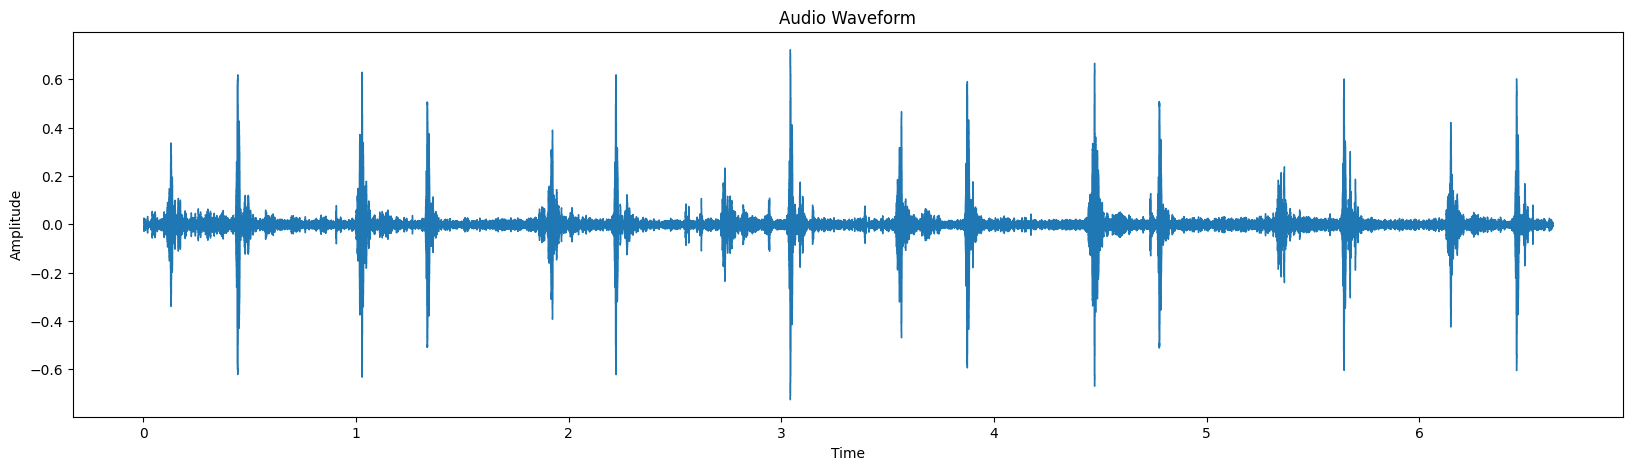

In [16]:
show_audio_waveform(normal_sample)

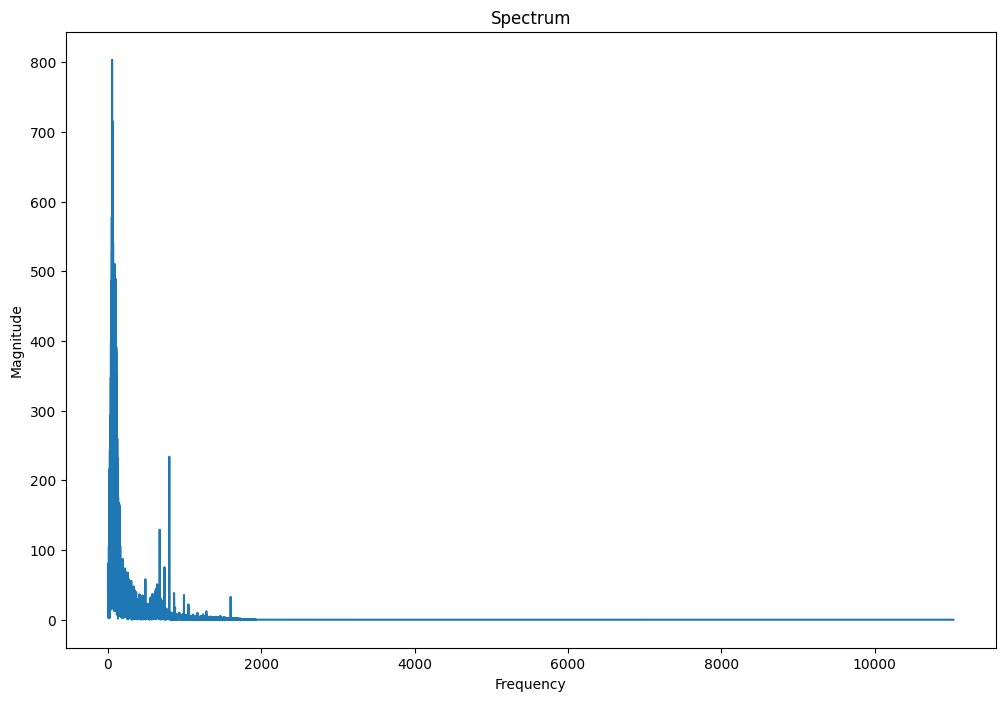

In [17]:
show_audio_spectrum(normal_sample)

STFT hop length duration is: 0.023219954648526078s
STFT window duration is: 0.09287981859410431s


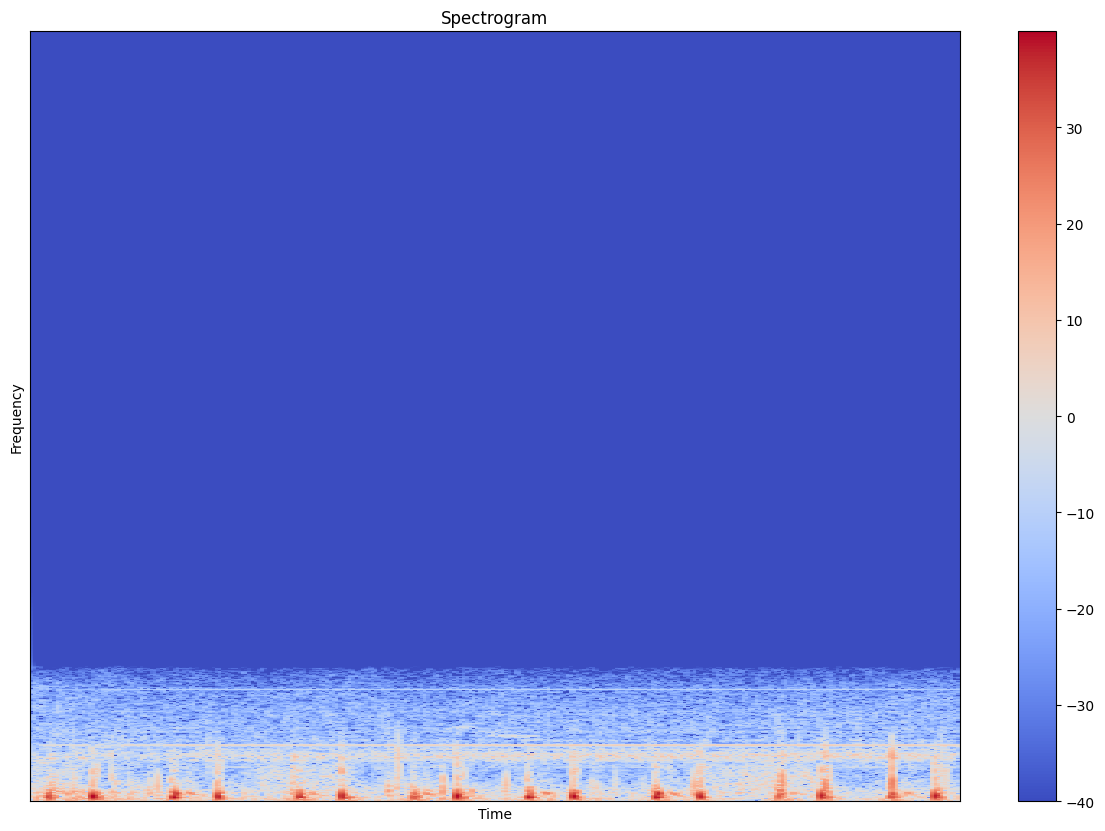

In [18]:
show_spectrogram(normal_sample)

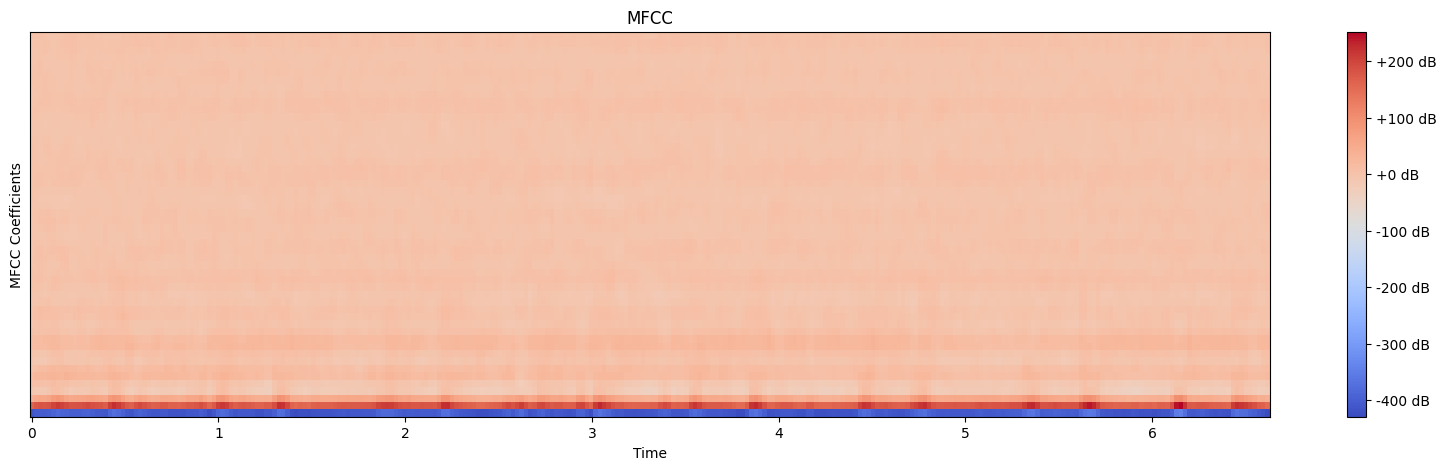

In [19]:
show_mfcc_features(normal_sample)

**Artifact Sounds**

In [20]:
artifact_audio, artifact_sample  = random_sound(artifact_data)
artifact_audio

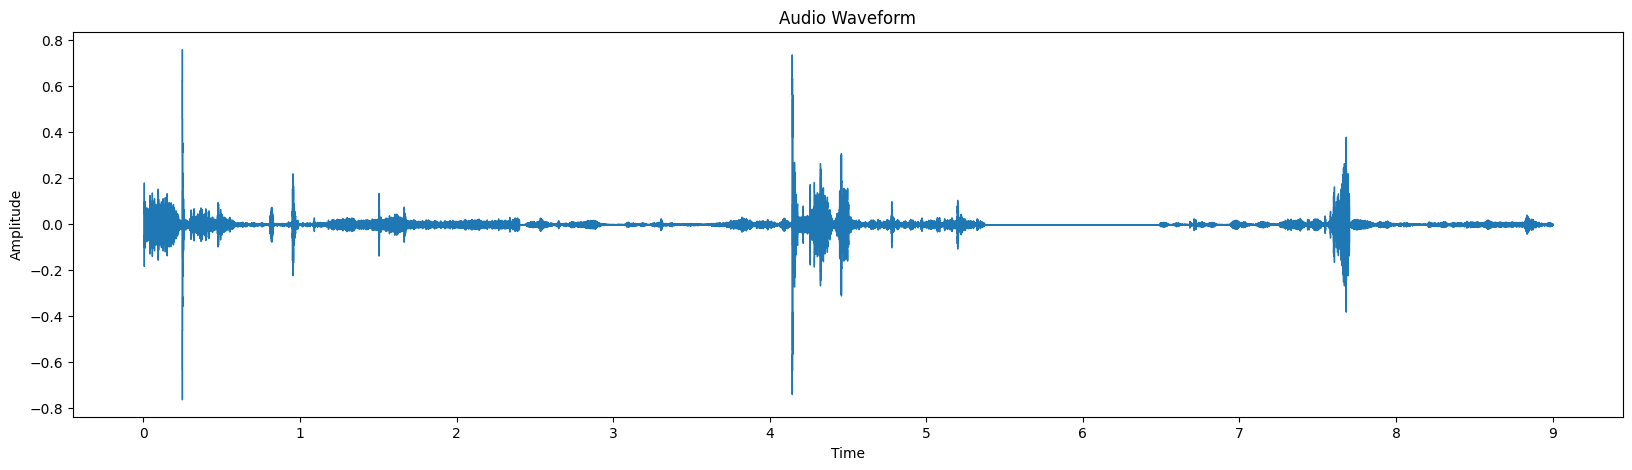

In [21]:
show_audio_waveform(artifact_sample)

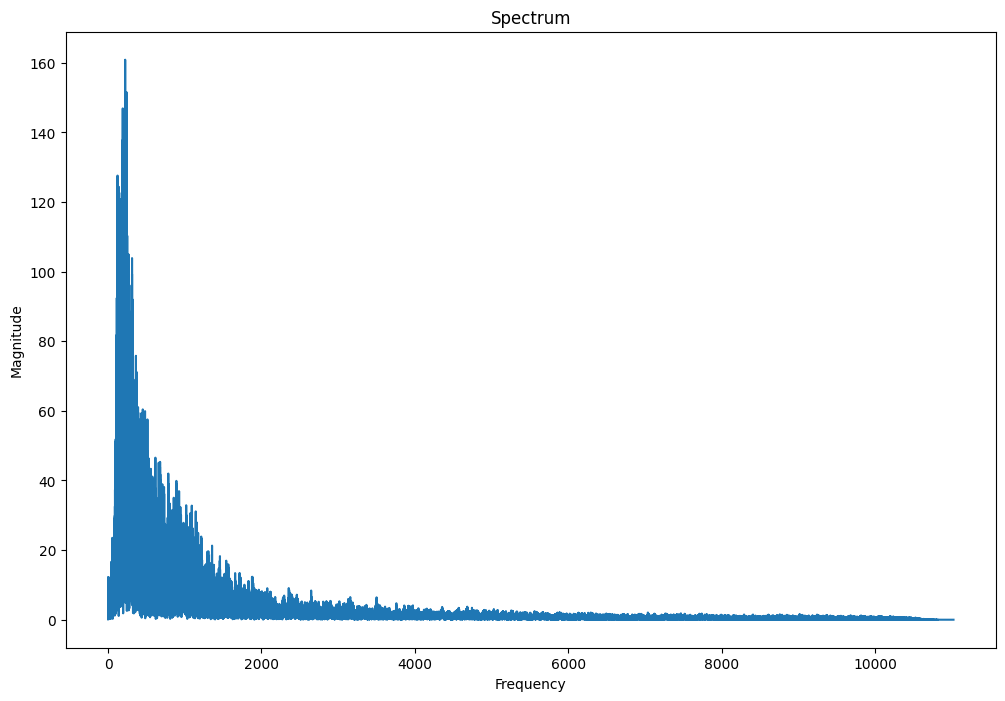

In [22]:
show_audio_spectrum(artifact_sample)

STFT hop length duration is: 0.023219954648526078s
STFT window duration is: 0.09287981859410431s


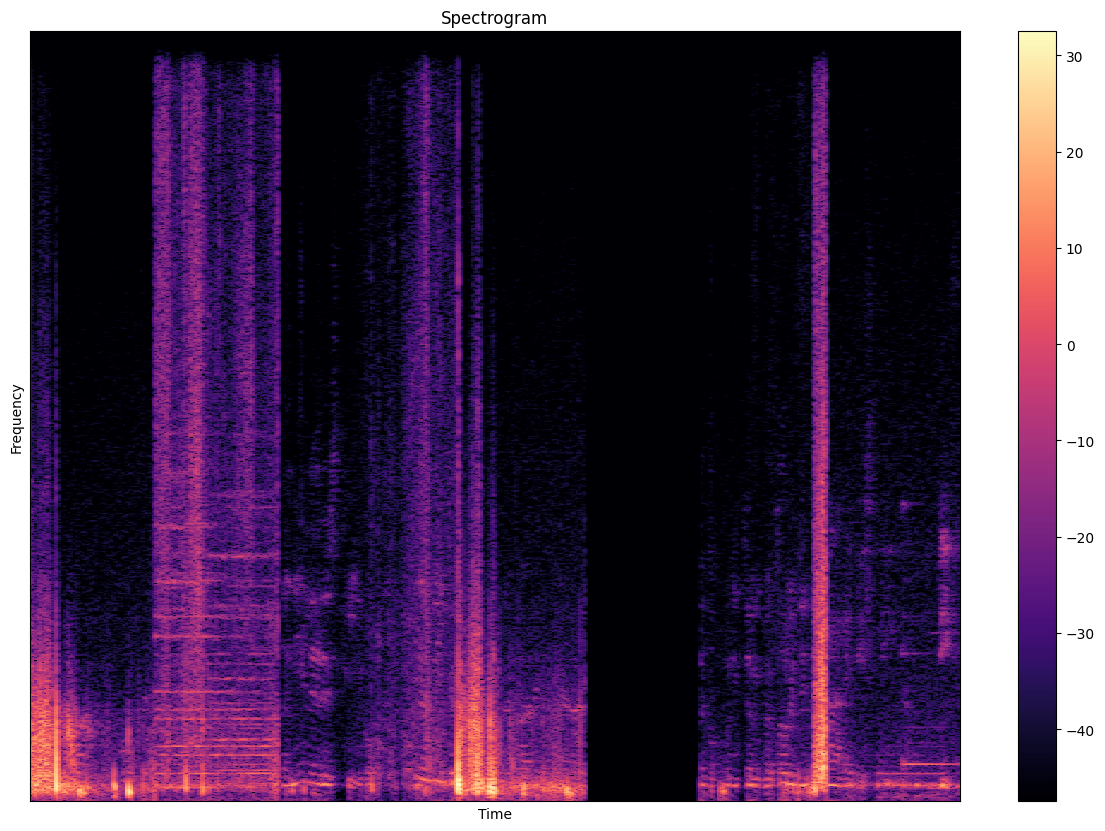

In [23]:
show_spectrogram(artifact_sample)

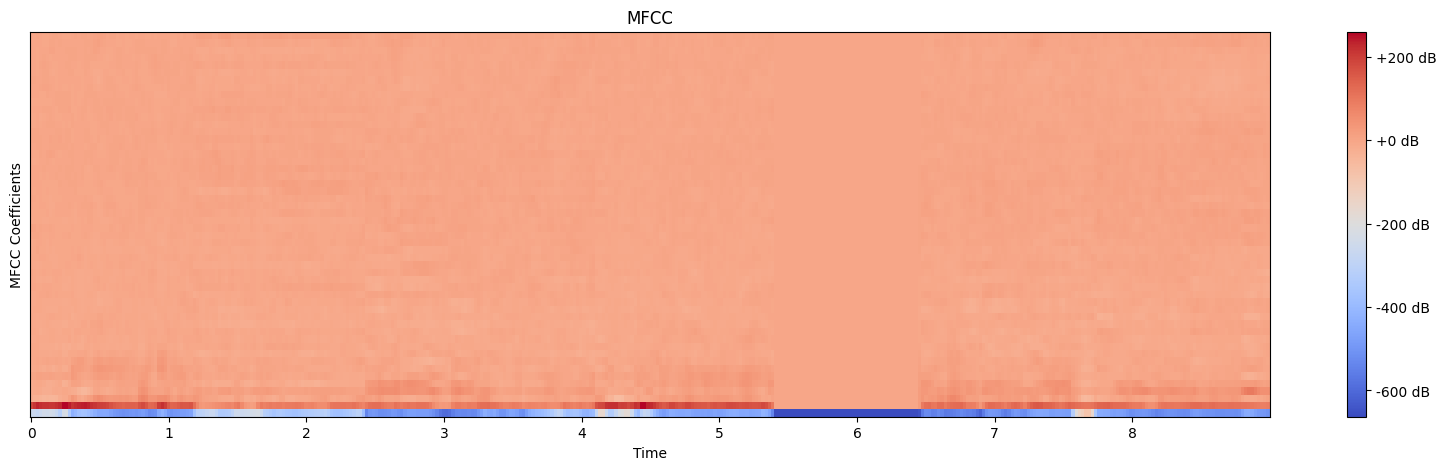

In [24]:
show_mfcc_features(artifact_sample)

**Extrahls**

In [25]:
extrahls_audio, extrahls_sample  = random_sound(extrahls_data)
extrahls_audio

STFT hop length duration is: 0.023219954648526078s
STFT window duration is: 0.09287981859410431s


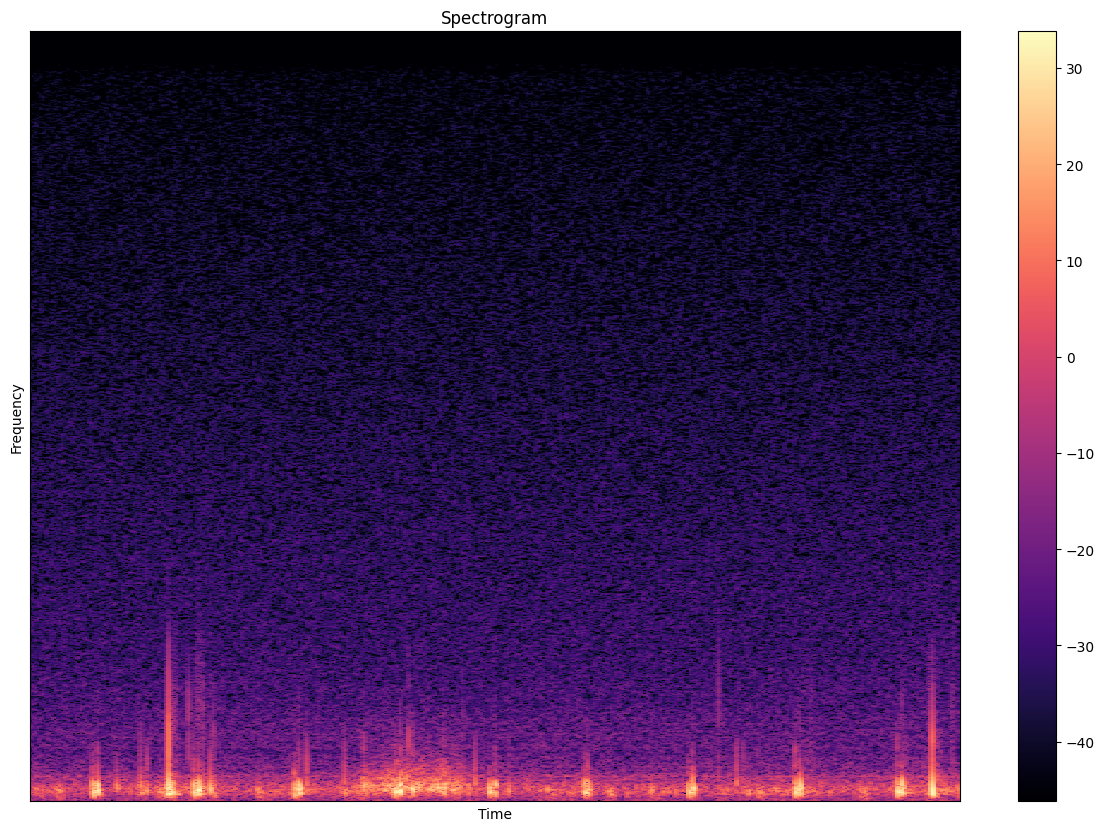

In [26]:
show_spectrogram(extrahls_sample)

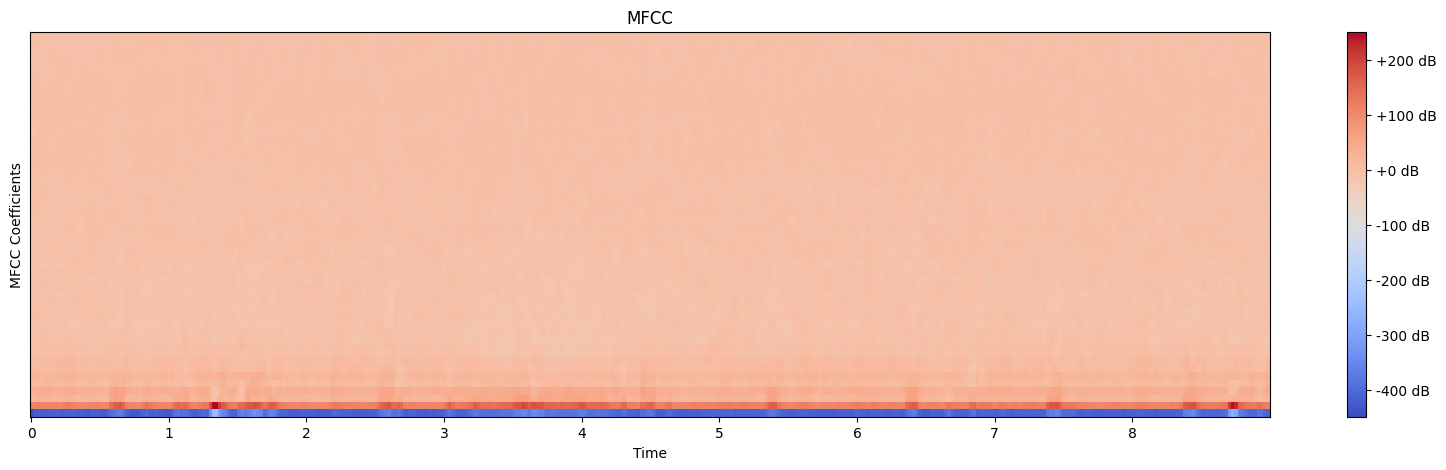

In [27]:
show_mfcc_features(extrahls_sample)

**Data Preprocessing**

In [28]:
def add_noise(data,x):
    noise = np.random.randn(len(data))
    data_noise = data + x * noise
    return data_noise

def shift(data,x):
    return np.roll(data, x)

def stretch(data, rate):
    data_stretched = librosa.effects.time_stretch(data, rate=rate)
    return data_stretched

def pitch_shift (data , rate):
    data = librosa.effects.pitch_shift(data, sr=220250, n_steps=rate)
    return data

In [29]:
def load_file_data (folder, file_names, duration=10, sr=22050):
    '''
        Extract MFCC feature from the Sound data from the audio data.
        Augmentation of sound data by adding Noise, streaching and shifting.
        52 features are extracted from each audio data and used to train the model.

        Args:
            dir_: Input directory to the Sound input file.

        Returns:
            data: list of features extracted from the sound file.
    '''
    input_length=sr*duration
    features = 52
    data = []
    for file_name in file_names:
        try:
            sound_file = folder+file_name
            X, sr = librosa.load( sound_file, sr=sr, duration=duration)
            dur = librosa.get_duration(y=X, sr=sr)
            # pad audio file same duration
            if (round(dur) < duration):
                print ("fixing audio lenght :", file_name)
                X = librosa.util.fix_length(X, size=input_length)
                           # extract normalized mfcc feature from data
            mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sr, n_mfcc=features).T,axis=0)
            feature = np.array(mfccs).reshape([-1,1])
            data.append(feature)

            stretch_data_1 = stretch (X, 0.8)
            mfccs_stretch_1 = np.mean(librosa.feature.mfcc(y=stretch_data_1, sr=sr, n_mfcc=features).T,axis=0)
            feature_1 = np.array(mfccs_stretch_1).reshape([-1,1])
            data.append(feature_1)

            stretch_data_2 = stretch (X, 1.2)
            mfccs_stretch_2 = np.mean(librosa.feature.mfcc(y=stretch_data_2, sr=sr, n_mfcc=features).T,axis=0)
            feature_2 = np.array(mfccs_stretch_2).reshape([-1,1])
            data.append(feature_2)

        except Exception as e:
                      print("Error encountered while parsing file: ", file_name)
                      print("Error message:", e)

    return data

**Encoding**

In [30]:
# simple encoding of categories, convert to only 3 types:
# Normal (Include extrahls and extrastole)
# Murmur
# Artifact

# Map label text to integer
CLASSES = ['artifact','murmur','normal']
NB_CLASSES=len(CLASSES)

# Map integer value to text labels
label_to_int = {k:v for v,k in enumerate(CLASSES)}
print (label_to_int)
print (" ")
int_to_label = {v:k for k,v in label_to_int.items()}
print(int_to_label)

{'artifact': 0, 'murmur': 1, 'normal': 2}
 
{0: 'artifact', 1: 'murmur', 2: 'normal'}


**Data Augmenation and Feature Extraction**

In [31]:
# 22 KHz
SAMPLE_RATE = 22050
# 10 seconds
MAX_SOUND_CLIP_DURATION=10

artifact_files = fnmatch.filter(os.listdir(artifact_data), 'artifact*.wav')
artifact_sounds = load_file_data (folder=artifact_data,file_names = artifact_files, duration=MAX_SOUND_CLIP_DURATION)
artifact_labels = [0 for items in artifact_sounds]

normal_files = fnmatch.filter(os.listdir(normal_data), 'normal*.wav')
normal_sounds = load_file_data(folder=normal_data,file_names=normal_files, duration=MAX_SOUND_CLIP_DURATION)
normal_labels = [2 for items in normal_sounds]

extrahls_files = fnmatch.filter(os.listdir(extrahls_data), 'extrahls*.wav')
extrahls_sounds = load_file_data(folder=extrahls_data,file_names=extrahls_files, duration=MAX_SOUND_CLIP_DURATION)
extrahls_labels = [2 for items in extrahls_sounds]

murmur_files = fnmatch.filter(os.listdir(murmur_data), 'murmur*.wav')
murmur_sounds = load_file_data(folder=murmur_data,file_names=murmur_files, duration=MAX_SOUND_CLIP_DURATION)
murmur_labels = [1 for items in murmur_sounds]


extrastole_files = fnmatch.filter(os.listdir(extrastole_data), 'extrastole*.wav')
extrastole_sounds = load_file_data(folder=extrastole_data,file_names=extrastole_files, duration=MAX_SOUND_CLIP_DURATION)
extrastole_labels = [2 for items in extrastole_sounds]

print ("Loading Done")

fixing audio lenght : artifact__201105041959.wav
fixing audio lenght : artifact__201106040933.wav
fixing audio lenght : artifact__201106021541.wav
fixing audio lenght : artifact__201105051017.wav
fixing audio lenght : artifact__201105280851.wav
fixing audio lenght : artifact__201012172012.wav
fixing audio lenght : artifact__201106010602.wav
fixing audio lenght : artifact__201106010559.wav
fixing audio lenght : artifact__201105061143.wav
fixing audio lenght : artifact__201106031558.wav
fixing audio lenght : artifact__201106030612.wav
fixing audio lenght : artifact__201105190800.wav
fixing audio lenght : artifact__201106040722.wav
fixing audio lenght : artifact__201105040918.wav
fixing audio lenght : artifact__201105060108.wav
fixing audio lenght : artifact__201106141701.wav
fixing audio lenght : artifact__201106131834.wav
fixing audio lenght : artifact__201106101314.wav
fixing audio lenght : artifact__201106061233.wav
fixing audio lenght : artifact__201106211430.wav
fixing audio lenght 

In [32]:
# unlabel_datala files
Bunlabelledtest_files = fnmatch.filter(os.listdir(unlabel_data), 'Bunlabelledtest*.wav')
Bunlabelledtest_sounds = load_file_data(folder=unlabel_data,file_names=Bunlabelledtest_files, duration=MAX_SOUND_CLIP_DURATION)
Bunlabelledtest_labels = [-1 for items in Bunlabelledtest_sounds]

Aunlabelledtest_files = fnmatch.filter(os.listdir(unlabel_data), 'Aunlabelledtest*.wav')
Aunlabelledtest_sounds = load_file_data(folder=unlabel_data,file_names=Aunlabelledtest_files, duration=MAX_SOUND_CLIP_DURATION)
Aunlabelledtest_labels = [-1 for items in Aunlabelledtest_sounds]


print ("Loading of unlabel data done")

fixing audio lenght : Bunlabelledtest__239_1309195730333_D.wav
fixing audio lenght : Bunlabelledtest__296_1311682952647_B.wav
fixing audio lenght : Bunlabelledtest__146_1306778707532_C.wav
fixing audio lenght : Bunlabelledtest__167_1307111318050_D.wav
fixing audio lenght : Bunlabelledtest__194_1308139824187_C.wav
fixing audio lenght : Bunlabelledtest__174_1307987737137_C.wav
fixing audio lenght : Bunlabelledtest__141_1306520154450_A.wav
fixing audio lenght : Bunlabelledtest__137_1306764999211_B1.wav
fixing audio lenght : Bunlabelledtest__148_1306768801551_D.wav
fixing audio lenght : Bunlabelledtest__189_1308075231945_A.wav
fixing audio lenght : Bunlabelledtest__103_1305031931979_C.wav
fixing audio lenght : Bunlabelledtest__173_1307973611151_D.wav
fixing audio lenght : Bunlabelledtest__132_1306758754432_B.wav
fixing audio lenght : Bunlabelledtest__272_1309370164386_B.wav
fixing audio lenght : Bunlabelledtest__109_1305653972028_B.wav
fixing audio lenght : Bunlabelledtest__155_13069359028

**Concatenation**

In [33]:
#combine set-a and set-b
x_data = np.concatenate((artifact_sounds, normal_sounds, extrahls_sounds, murmur_sounds, extrastole_sounds))
y_data = np.concatenate((artifact_labels, normal_labels, extrahls_labels, murmur_labels, extrastole_labels))

test_x = np.concatenate((Aunlabelledtest_sounds,Bunlabelledtest_sounds))
test_y = np.concatenate((Aunlabelledtest_labels,Bunlabelledtest_labels))

print ("combined training data record: ",len(y_data), len(test_y))

combined training data record:  1755 741


**Data Split**

In [34]:
# shuffle - whether or not to shuffle the data before splitting. If shuffle=False then stratify must be None.

# split data into Train, Validation and Test
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, train_size=0.8, random_state=42, shuffle=True)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, train_size=0.9, random_state=42, shuffle=True)

# One-Hot encoding for classes
y_train = np.array(tf.keras.utils.to_categorical(y_train, len(CLASSES)))
y_test = np.array(tf.keras.utils.to_categorical(y_test, len(CLASSES)))
y_val = np.array(tf.keras.utils.to_categorical(y_val, len(CLASSES)))
test_y=np.array(tf.keras.utils.to_categorical(test_y, len(CLASSES)))

**Correct Imbalanced Data**

In [35]:
# class weight
TRAIN_IMG_COUNT = 578
COUNT_0 = 40  #artifact
COUNT_1 = 129 #murmur
COUNT_2 = 409 #normal
weight_for_0 = TRAIN_IMG_COUNT / (3 * COUNT_0)
weight_for_1 = TRAIN_IMG_COUNT / (3 * COUNT_1)
weight_for_2 = TRAIN_IMG_COUNT / (3 * COUNT_2)
class_weight = {0: weight_for_0, 1: weight_for_1, 2: weight_for_2}
class_weight

{0: 4.816666666666666, 1: 1.4935400516795865, 2: 0.4710676446617767}

In [36]:
 # Step 2: Load and preprocess the data using STFT
def load_data(data_dir):
    data = []
    labels = []
    for category in ["normal", "abnormal"]:
        folder = os.path.join(data_dir, category)
        label = 0 if category == "normal" else 1
        for filename in os.listdir(folder):
            if filename.endswith(".wav"):
                file_path = os.path.join(folder, filename)
                y, sr = librosa.load(file_path, sr=None)
                # Compute the STFT
                D = np.abs(librosa.stft(y))**2
                # Convert to dB scale
                spectrogram_db = librosa.amplitude_to_db(D, ref=np.max)
                data.append(spectrogram_db)
                labels.append(label)
    return np.array(data), np.array(labels)

In [39]:

# Assuming `data` is your spectrogram data and `labels` are the corresponding labels
def preprocess_data(data, time_steps):
    # Normalize data if necessary
    data = np.array(data)

    # Reshape data to fit the LSTM input shape
    num_samples = data.shape[0]
    reshaped_data = data.reshape(num_samples, time_steps, 1)

    return reshaped_data

# Preprocess the training, validation, and test data
time_steps = 52  # This should match the expected input length for your model
x_train_lstm = preprocess_data(x_train_lstm, time_steps)
x_val_lstm = preprocess_data(x_val_lstm, time_steps)
x_test_lstm = preprocess_data(x_test_lstm, time_steps)


**LSTM Model**

In [38]:
x_train_lstm = x_train
x_val_lstm = x_test
x_test_lstm = x_val

y_train_lstm = y_train
y_val_lstm = y_test
y_test_lstm = y_val

**Build Model**

In [40]:
lstm_model = Sequential()

lstm_model.add(Conv1D(2048, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(52, 1)))
lstm_model.add(MaxPooling1D(pool_size=2, strides = 2, padding = 'same'))
lstm_model.add(BatchNormalization())

lstm_model.add(Conv1D(1024, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(52, 1)))
lstm_model.add(MaxPooling1D(pool_size=2, strides = 2, padding = 'same'))
lstm_model.add(BatchNormalization())

lstm_model.add(Conv1D(512, kernel_size=5, strides=1, padding='same', activation='relu'))
lstm_model.add(MaxPooling1D(pool_size=2, strides = 2, padding = 'same'))
lstm_model.add(BatchNormalization())

lstm_model.add(LSTM(256, return_sequences=True))
lstm_model.add(LSTM(128))


lstm_model.add(Dense(64, activation='relu'))
lstm_model.add(Dropout(0.5))

lstm_model.add(Dense(32, activation='relu'))
lstm_model.add(Dropout(0.5))

lstm_model.add(Dense(3, activation='softmax'))

lstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 52, 2048)          12288     
                                                                 
 max_pooling1d (MaxPooling1  (None, 26, 2048)          0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 26, 2048)          8192      
 Normalization)                                                  
                                                                 
 conv1d_1 (Conv1D)           (None, 26, 1024)          10486784  
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 13, 1024)          0         
 g1D)                                                            
                                                        

In [41]:
optimiser = tf.keras.optimizers.Adam(learning_rate = 0.0001)
lstm_model.compile(optimizer=optimiser,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

In [42]:
# Reshape the input data
x_train_lstm = x_train_lstm.reshape(-1, 52, 1)
x_val_lstm = x_val_lstm.reshape(-1, 52, 1)

# Verify the shapes
print(x_train_lstm.shape)  # Should be (number_of_samples, 52, 1)
print(x_val_lstm.shape)    # Should be (number_of_samples, 52, 1)

# Fit the model
history = lstm_model.fit(
    x_train_lstm, y_train_lstm,
    validation_data=(x_val_lstm, y_val_lstm),
    batch_size=8, epochs=250,
    class_weight=class_weight
)

(1263, 52, 1)
(351, 52, 1)
Epoch 1/250
158/158 [==============================] - 17s 29ms/step - loss: 0.9064 - accuracy: 0.4252 - val_loss: 0.8609 - val_accuracy: 0.2735
Epoch 2/250
158/158 [==============================] - 4s 22ms/step - loss: 0.7825 - accuracy: 0.5099 - val_loss: 0.8266 - val_accuracy: 0.2479
Epoch 3/250
158/158 [==============================] - 4s 23ms/step - loss: 0.7005 - accuracy: 0.5289 - val_loss: 1.1040 - val_accuracy: 0.4701
Epoch 4/250
158/158 [==============================] - 3s 21ms/step - loss: 0.6775 - accuracy: 0.5368 - val_loss: 0.7777 - val_accuracy: 0.5926
Epoch 5/250
158/158 [==============================] - 3s 21ms/step - loss: 0.6392 - accuracy: 0.5748 - val_loss: 0.8058 - val_accuracy: 0.6866
Epoch 6/250
158/158 [==============================] - 4s 22ms/step - loss: 0.6459 - accuracy: 0.5740 - val_loss: 0.7128 - val_accuracy: 0.6581
Epoch 7/250
158/158 [==============================] - 4s 24ms/step - loss: 0.5989 - accuracy: 0.5740 - val_

In [43]:
lstm_model.evaluate(x_val_lstm, y_val_lstm)

11/11 [==============================] - 1s 41ms/step - loss: 0.1357 - accuracy: 0.9829


[0.1357267051935196, 0.9829059839248657]

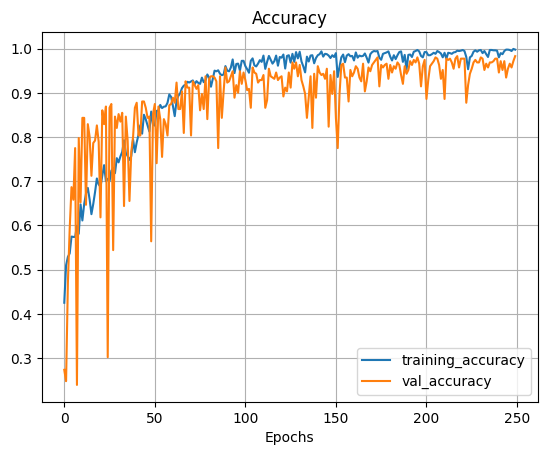

In [44]:
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  Args:
    history: TensorFlow model History object (see: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History)
  """
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
#   plt.plot(epochs, loss, label='training_loss')
#   plt.plot(epochs, val_loss, label='val_loss')
#   plt.title('Loss')
#   plt.xlabel('Epochs')
#   plt.legend()
#   plt.grid()


  # Plot accuracy
  plt.figure()
  plt.grid()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

plot_loss_curves(history)

5/5 [==============================] - 2s 94ms/step


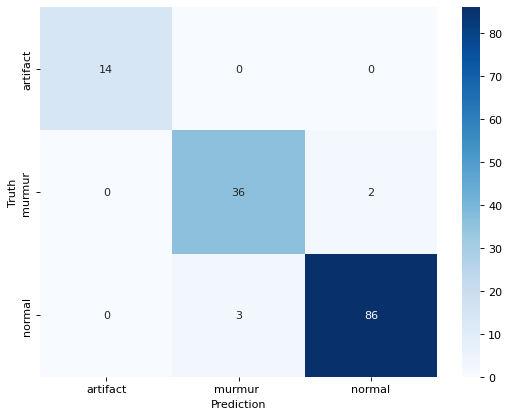

In [45]:
classes = ["artifact" ,"murmur ", "normal"]

preds = lstm_model.predict(x_test_lstm)
classpreds = [ np.argmax(t) for t in preds ]
y_testclass = [np.argmax(t) for t in y_test_lstm]
cm = confusion_matrix(y_testclass, classpreds)

plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
ax = sns.heatmap(cm, cmap='Blues', annot=True, fmt='d', xticklabels=classes, yticklabels=classes)

plt.title('')
plt.xlabel('Prediction')
plt.ylabel('Truth')
plt.show(ax)

In [46]:
print(classification_report(y_testclass, classpreds, target_names=classes))

              precision    recall  f1-score   support

    artifact       1.00      1.00      1.00        14
     murmur        0.92      0.95      0.94        38
      normal       0.98      0.97      0.97        89

    accuracy                           0.96       141
   macro avg       0.97      0.97      0.97       141
weighted avg       0.96      0.96      0.96       141



In [64]:
from tensorflow.keras.models import load_model

# Load your pre-trained LSTM model
lstm_model = load_model('/content/drive/MyDrive/MODEL/oaLSTMcnn.h5')

def heart_prediction(file_path, duration=10, sr=22050):
    classes = ["artifact", "murmur", "normal"]
    input_length = sr * duration

    X, sr = librosa.load(file_path, sr=sr, duration=duration)
    dur = librosa.get_duration(y=X, sr=sr)

    # Pad audio file if necessary
    if round(dur) < duration:
        X = librosa.util.fix_length(X, size=input_length)

    # Extract MFCC features
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sr, n_mfcc=52, n_fft=512, hop_length=2048).T, axis=0)
    feature = np.array(mfccs).reshape(1, 52, 1)

    # Predict using the LSTM model
    preds = lstm_model.predict(feature)
    predicted_class = classes[np.argmax(preds)]
    confidence = np.amax(preds)

    return predicted_class, confidence


In [79]:
file_path = '/content/drive/MyDrive/Heartbeat_Sound/unlabel/Aunlabelledtest__201106120928.wav'
predicted_class, confidence = heart_prediction(file_path)
print(f'Predicted Class: {predicted_class}, Confidence: {confidence}')

1/1 [==============================] - 0s 57ms/step
Predicted Class: artifact, Confidence: 1.0
